#**Data Preprocessing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'topic-tagging'

import sys
sys.path.append('/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/topic-tagging


In [ ]:
import re
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from gensim.models.keyedvectors import KeyedVectors
word_vect = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

In [ ]:
idToTagIndex = {}          #dict mapping post ID to a list of tag indices
tagToTagIndex = {}         #dict mapping tag to tag index

In [ ]:
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

In [ ]:
with open("Questions-ascii-1M.csv") as question_input:
    questions_data = pd.read_csv(question_input, engine='python')

    print(questions_data.columns)
    questions_data = questions_data[['Id', 'Title', 'Body']]
    questions_data.insert(len(questions_data.columns), 'Code', "")


    a = re.compile(r'<pre><code>([^<]*)</code></pre>')
    b = re.compile(r'<.*?>')
    questions_data['Code'] = questions_data['Body'].apply(lambda x: ' '.join(re.findall(a, x)))

    def clean(text):
        x = re.sub(a, '', text)
        x = re.sub(b, '', x)
        x = x.replace('\n\n', '\n')
        return x
    questions_data['Body'] = questions_data['Title'].str.cat(questions_data['Body'], sep=" ")
    questions_data['Body'] = questions_data['Body'].apply(clean)

Index(['Id', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Score', 'Title',
       'Body'],
      dtype='object')


In [ ]:
from collections import defaultdict

idToTagIndex = {}          #dict mapping post ID to a list of tag indices
tagToTagIndex = {}         #dict mapping tag to tag index
tagIndexToTag = {}
tagToFrequency = defaultdict(lambda: 0)

with open("tags-1M.csv") as tag_input:
    tag_data = pd.read_csv(tag_input)
    tagIndex = 0
    for index, row in tqdm(tag_data.iterrows()):
        currId = int(row[0])
        currTag = row[1]
        if currTag not in tagToTagIndex:
            tagToTagIndex[currTag] = tagIndex
            tagIndexToTag[tagIndex] = currTag
            currTagIndex = tagIndex
            tagIndex += 1

        else:
            currTagIndex = tagToTagIndex[currTag]  
        
        tagToFrequency[currTagIndex] += 1        
    
        if currId not in idToTagIndex.keys():
            idToTagIndex[currId] = [tagToTagIndex[row[1]]]
        else:
            idToTagIndex[currId].append(tagToTagIndex[row[1]])
            

152759it [00:13, 11420.99it/s]


In [ ]:
print("Number of examples: ", len(idToTagIndex))

Number of examples:  53203


In [ ]:
n = 10      #number of top tags; can be changed

tagToFrequencyList = []

for key, value in tagToFrequency.items():
    temp = [key, value]
    tagToFrequencyList.append(temp)
    
tagToFrequencyList.sort(reverse=True, key=lambda x: x[1])

for tag in tagToFrequencyList[:n]:
    print(f"{tagIndexToTag[tag[0]]} ({tag[0]}): {tag[1]} times")
    
mostCommonTags = {}
for counter, tag in enumerate(tagToFrequencyList[:n]):   #currently takes top 10 tags
    mostCommonTags[tag[0]] = counter


c# (14): 6722 times
java (89): 3858 times
.net (15): 3598 times
php (76): 3223 times
asp.net (8): 3041 times
javascript (132): 2852 times
c++ (18): 2509 times
jquery (370): 2198 times
iphone (607): 2111 times
python (196): 2070 times


In [ ]:
idToTenTags = {}

numTagsCount = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}

for postId, tags in idToTagIndex.items():
    containsTopTenTags = [mostCommonTags[tag] for tag in tags if tag in mostCommonTags.keys()]
    idToTenTags[postId] = containsTopTenTags
    numTagsCount[len(containsTopTenTags)] += 1
    
    
questions_data['Top-Tags'] = questions_data['Id'].apply(lambda x: idToTenTags[x])

print(questions_data)
print("")
for key in numTagsCount:
  print(f"{numTagsCount[key]} posts with {key} tags")

            Id  ... Top-Tags
0           80  ...       []
1           90  ...       []
2          120  ...      [4]
3          180  ...       []
4          260  ...   [0, 2]
...        ...  ...      ...
53198  2495810  ...       []
53199  2495870  ...      [2]
53200  2495890  ...   [0, 4]
53201  2495910  ...       []
53202  2496040  ...   [3, 5]

[53203 rows x 5 columns]

25567 posts with 0 tags
23383 posts with 1 tags
3972 posts with 2 tags
269 posts with 3 tags
12 posts with 4 tags
0 posts with 5 tags


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(questions_data['Body'].values.tolist())
vectorizer.adapt(text_ds)
vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'to', 'i', 'a', 'is', 'in', 'and', 'of']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

questions_X = vectorizer(np.array([[s] for s in questions_data['Body'].values])).numpy()
questions_y = mlb.fit_transform(np.array(questions_data['Top-Tags'].values))
print(questions_y[:5])

train_X, test_X, train_y, test_y = train_test_split(questions_X, questions_y, train_size=0.75, random_state=200)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0 0]]


In [ ]:
#TEST
# output = vectorizer([["Does anyone know how to use javascript arrow functions?"]])
# output.numpy()

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
# test = ["this", "line", "of", "code"]
# [word_index[w] for w in test] 

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 200
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tqdm(word_index.items()):
    try:
        embedding_vector = word_vect.get_vector(word)
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    except:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

100%|██████████| 20000/20000 [00:00<00:00, 274155.43it/s]

Converted 18723 words (1277 misses)


In [ ]:
from tensorflow.keras import layers
from keras.layers import Embedding
from keras.models import Sequential

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
from sklearn.utils import class_weight
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

weights = {}
for i in range(n):
    weights[i] = (1 / tagToFrequencyList[i][1])
vals = [val for val in weights.values()]

#**CNN-6**

In [ ]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
# x = layers.MaxPooling1D(5)(x)
# x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
# x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
# x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
# x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="sigmoid")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(n)(x)
preds = layers.Activation(activation="sigmoid")(preds)
model = keras.Model(int_sequences_input, preds)
model.summary()
keras.utils.plot_model(model,"image.png", show_shapes=True)


NameError: ignored

In [ ]:
model.compile(
              tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2), precision_m, f1_m, tf.keras.metrics.AUC(curve="PR", multi_label=True, label_weights=vals)])

history = model.fit(train_X, train_y, batch_size=64, epochs=15, validation_data=(test_X, test_y), class_weight=weights)

NameError: ignored

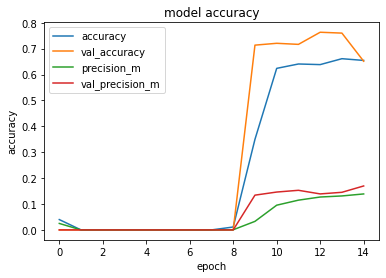

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'precision_m', 'val_precision_m', 'f1_m', 'val_f1_m'], loc='upper left')
plt.show()

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    ["I wanted to open my app without safari system alert but I found out that is impossible. so i decided to handle this alert event but I couldn't find the way. if I click [open], then safari open App, but if I click [cancel], then 'appCheckTimer' will be executed, then safari moves to 'some page's url'. if there is no way to not open this alert, I want to handle this alert's button event, when user click [cancel], I just want to stay that page. that alert is not opened by me, it's by safari So I can't handle it."]
    # ["Can someone explain to me what System.out.println is"],
    # ["I dropped my iphone today"]
    # ["I try to create a person detection model with Tensorflow object detection api. I'm using Tensorflow 2. But at the end, the model has poor accuracy. It is detecting persons on image, but it only predicts between 30-60%."]
    # ["Using Linux mint which has multiple packages installed. I have installed opencv and imutils using sudo pip3 install opencv and sudo pip3 install imutils."]
)

for i, prob in np.ndenumerate(probabilities):
    print('{:<16}  {:<16}'.format(tagIndexToTag[tagToFrequencyList[i[1]][0]], truncate(prob, 3)))
print(f"\nMost likely tag: {tagIndexToTag[tagToFrequencyList[np.argmax(probabilities)][0]]}")

c#                0.074           
java              0.028           
.net              0.07            
php               0.163           
asp.net           0.155           
javascript        0.233           
c++               0.073           
jquery            0.224           
iphone            0.221           
python            0.201           

Most likely tag: javascript


In [ ]:
model.evaluate(test_X, test_y)
model.evaluate(train_X, train_y)

1247/1247 [==============================] - 6s 5ms/step - loss: 0.1573 - accuracy: 0.3881 - top_k_categorical_accuracy: 0.7792 - precision_m: 0.6695 - f1_m: 0.1732 - auc: 0.3372


[0.1572781652212143,
 0.38805073499679565,
 0.7792090773582458,
 0.6694574952125549,
 0.1732446700334549,
 0.3371765911579132]

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
import itertools
import matplotlib.pyplot as plt
y_pred = model.predict(test_X)
print(y_pred.shape)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)
cm = multilabel_confusion_matrix(y_true, y_pred)
print(cm)

(13301, 10)
[[[ 4753   585]
  [ 5681  2282]]

 [[ 9970  2338]
  [  112   881]]

 [[12818     0]
  [  483     0]]

 [[10369  2113]
  [  181   638]]

 [[12680   118]
  [  482    21]]

 [[11555  1134]
  [  142   470]]

 [[10779  1916]
  [  171   435]]

 [[13001     0]
  [  300     0]]

 [[12762    10]
  [  528     1]]

 [[12566   242]
  [  376   117]]]


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="grey" if cm[i, j] > thresh else "black") #originally "white" instead of grey
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="grey" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

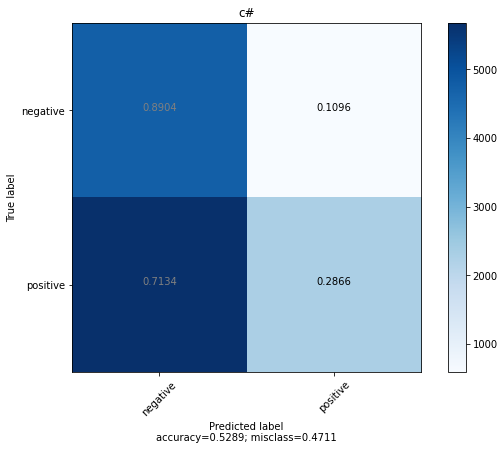

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

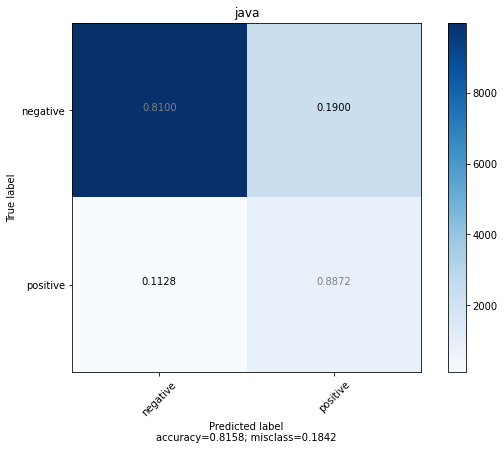

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

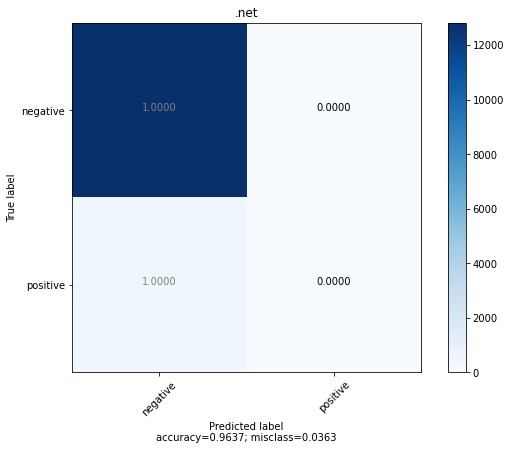

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

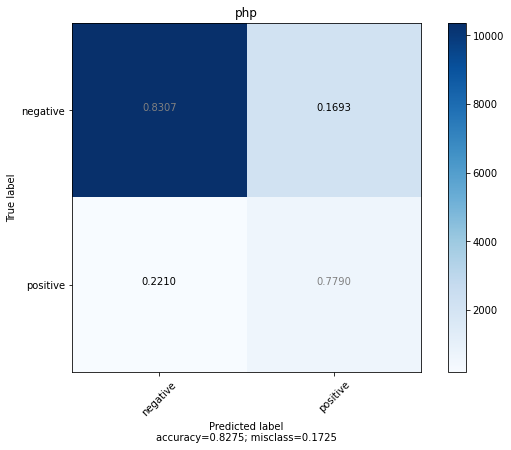

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

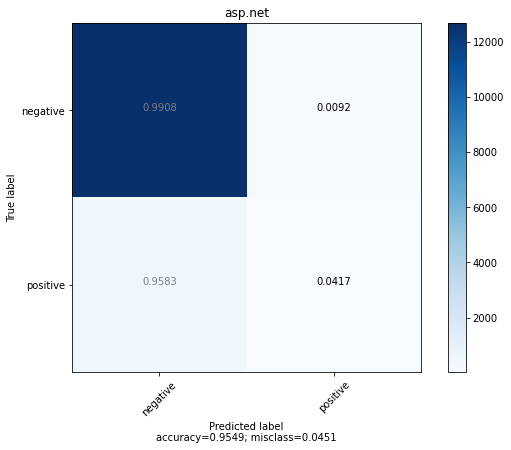

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

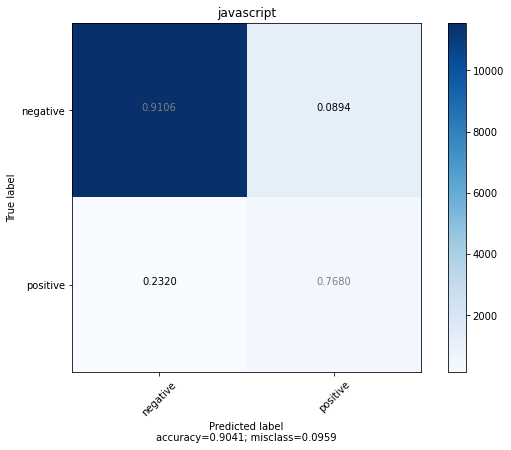

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

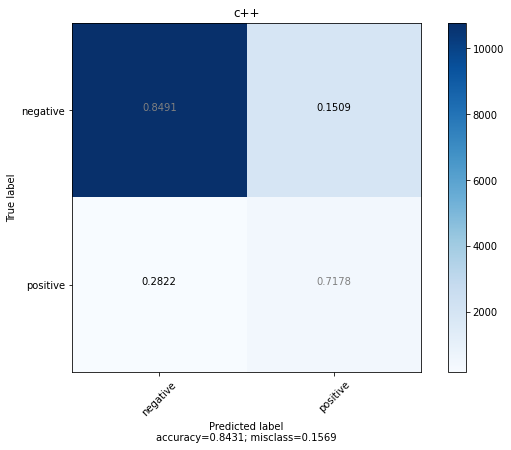

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

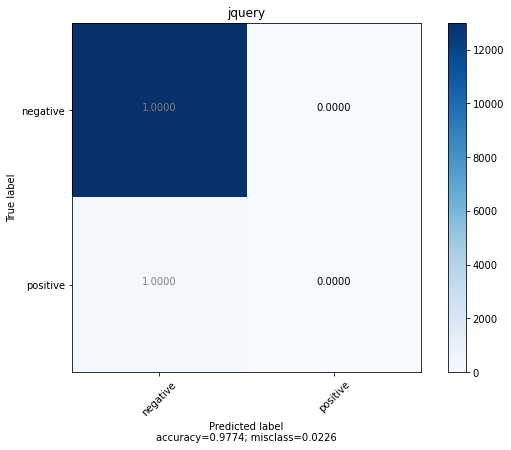

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

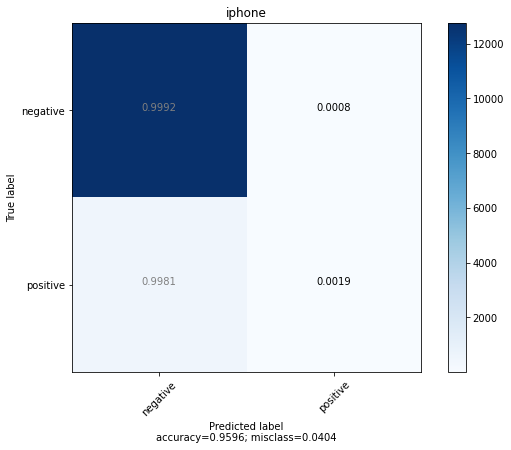

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

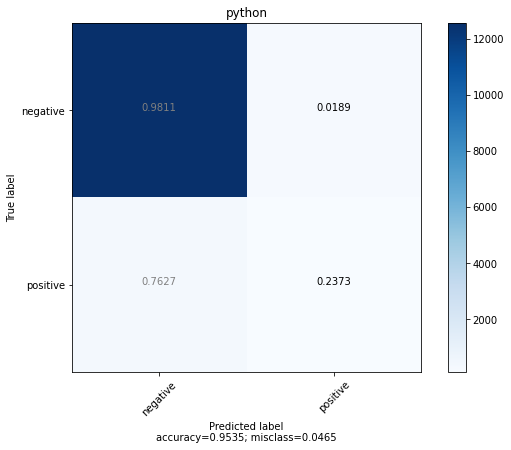

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [ ]:
from google.colab import files
for i in range(cm.shape[0]):
  conf_m = plot_confusion_matrix(cm[i, :, :], ['negative', 'positive'], title=tagIndexToTag[tagToFrequencyList[i][0]])
  plt.savefig(f"confusion-matrix-{i}.png")
  files.download(f"confusion-matrix-{i}.png") 

#**CNN-6 with Skip Connections**

In [ ]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x_shortcut = layers.Lambda(lambda x: keras.backend.mean(x, axis=1))(embedded_sequences)
x_shortcut = layers.Dense(n, activation="sigmoid")(x_shortcut)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
# x = layers.MaxPooling1D(5)(x)
# x = layers.Conv1D(128, 5, activation="relu")(x)
# x = layers.MaxPooling1D(5)(x)
# x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="sigmoid")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(mostCommonTags))(x) #change to all tags
# preds = layers.Softmax(axis=-1)(preds)
preds = layers.Add()([preds, x_shortcut])
preds = layers.Activation(activation="sigmoid")(preds)
skip_model = keras.Model(int_sequences_input, preds)
keras.utils.plot_model(skip_model,"image.png", show_shapes=True)
skip_model.summary()

NameError: ignored

In [ ]:
from sklearn.utils import class_weight
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

weights = {}

for i in range(n):
    weights[i] = (1 / tagToFrequencyList[i][1])
vals = [val for val in weights.values()]

skip_model.compile(
              tf.keras.optimizers.RMSprop(learning_rate=0.001),
              # optimizer = keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              # metrics=['accuracy', 'top_k_categorical_accuracy', recall_m, precision_m, f1_m])
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2), precision_m, f1_m, tf.keras.metrics.AUC(curve="PR", multi_label=True, label_weights=vals)])


history = skip_model.fit(train_X, train_y, batch_size=64, epochs=15, validation_data=(test_X, test_y), class_weight=weights)

NameError: ignored

In [ ]:
print("Test results:")
skip_model.evaluate(test_X, test_y)
print("Train results:")
skip_model.evaluate(train_X, train_y)

Test results:
333/333 [==============================] - 2s 5ms/step - loss: 0.1510 - accuracy: 0.6696 - top_k_categorical_accuracy: 0.8876 - precision_m: 0.7323 - f1_m: 0.6168 - auc_3: 0.6933
Train results:
1331/1331 [==============================] - 7s 5ms/step - loss: 0.0593 - accuracy: 0.7722 - top_k_categorical_accuracy: 0.9538 - precision_m: 0.8493 - f1_m: 0.7811 - auc_3: 0.8775


[0.05925869196653366,
 0.7722146511077881,
 0.9538320302963257,
 0.8492878079414368,
 0.7810794115066528,
 0.8774672746658325]

#**Baseline Model**

In [ ]:
baseline_model = Sequential()
baseline_model.add(Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
# Average the output of the Embedding layer over the word dimension
baseline_model.add(keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1)))
baseline_model.add(layers.Dense(n, activation="sigmoid"))

baseline_model.summary()

NameError: ignored

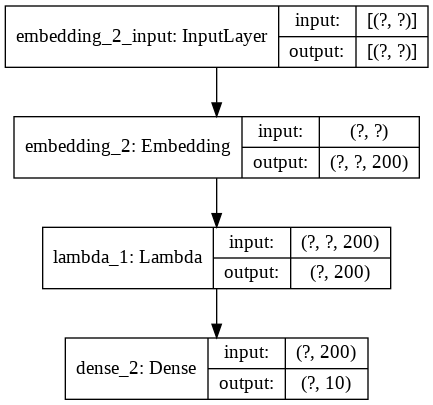

In [ ]:
keras.utils.plot_model(baseline_model,"image.png", show_shapes=True)

In [ ]:
for i in range(n):
    weights[i] = (1 / tagToFrequencyList[i][1])
vals = [val for val in weights.values()]

baseline_model.compile(
              optimizer='rmsprop',
              # optimizer = keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              # metrics=['accuracy', 'top_k_categorical_accuracy', recall_m, precision_m, f1_m])
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2), precision_m, f1_m, tf.keras.metrics.AUC(curve="PR", multi_label=True, label_weights=vals)])


history = baseline_model.fit(train_X, train_y, batch_size=64, epochs=15, validation_data=(test_X, test_y), class_weight=weights)
baseline_model.evaluate(test_X, test_y)
baseline_model.evaluate(train_X, train_y)

Epoch 1/15
666/666 [==============================] - 5s 8ms/step - loss: 7.4952e-05 - accuracy: 0.2809 - top_k_categorical_accuracy: 0.4597 - precision_m: 0.0153 - f1_m: 0.0029 - auc_1: 0.0640 - val_loss: 0.2431 - val_accuracy: 0.3096 - val_top_k_categorical_accuracy: 0.4750 - val_precision_m: 0.0689 - val_f1_m: 0.0045 - val_auc_1: 0.1658
Epoch 2/15
666/666 [==============================] - 5s 7ms/step - loss: 5.7084e-05 - accuracy: 0.3238 - top_k_categorical_accuracy: 0.4919 - precision_m: 0.3629 - f1_m: 0.0344 - auc_1: 0.2304 - val_loss: 0.2118 - val_accuracy: 0.3405 - val_top_k_categorical_accuracy: 0.5165 - val_precision_m: 0.5063 - val_f1_m: 0.0664 - val_auc_1: 0.3096
Epoch 3/15
666/666 [==============================] - 5s 7ms/step - loss: 5.0899e-05 - accuracy: 0.3327 - top_k_categorical_accuracy: 0.5059 - precision_m: 0.5897 - f1_m: 0.0973 - auc_1: 0.3309 - val_loss: 0.1949 - val_accuracy: 0.3464 - val_top_k_categorical_accuracy: 0.5163 - val_precision_m: 0.6313 - val_f1_m: 0

[0.15273897349834442,
 0.4057140052318573,
 0.6027677059173584,
 0.664389431476593,
 0.33361661434173584,
 0.5284961462020874]



```
# This is formatted as code
```

#**LSTM Model**

In [ ]:
lstm_model = Sequential()
# Configuring the parameters
lstm_model.add(Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
lstm_model.add(layers.LSTM(128, return_sequences=True))  
lstm_model.add(layers.Dropout(0.5))
lstm_model.add(layers.LSTM(64))
lstm_model.add(layers.Dropout(0.5))
# Adding a dense output layer with sigmoid activation
lstm_model.add(layers.Dense(n, activation="sigmoid"))
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 200)         4000400   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         168448    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 4,218,906
Trainable params: 218,506
Non-trainable params: 4,000,400
________________________________________

In [ ]:
for i in range(n):
    weights[i] = (1 / tagToFrequencyList[i][1])
vals = [val for val in weights.values()]

lstm_model.compile(
              optimizer='rmsprop',
              # optimizer = keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              # metrics=['accuracy', 'top_k_categorical_accuracy', recall_m, precision_m, f1_m])
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2), precision_m, f1_m, tf.keras.metrics.AUC(curve="PR", multi_label=True, label_weights=vals)])
history = lstm_model.fit(train_X, train_y, batch_size=64, epochs=15, validation_data=(test_X, test_y), class_weight=weights)



Epoch 1/15
666/666 [==============================] - 19s 29ms/step - loss: 6.6520e-05 - accuracy: 0.1042 - top_k_categorical_accuracy: 0.2215 - precision_m: 0.0048 - f1_m: 0.0016 - auc_10: 0.0540 - val_loss: 0.2291 - val_accuracy: 0.5877 - val_top_k_categorical_accuracy: 0.6333 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_auc_10: 0.0573
Epoch 2/15
666/666 [==============================] - 19s 28ms/step - loss: 6.3449e-05 - accuracy: 0.1134 - top_k_categorical_accuracy: 0.2416 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - auc_10: 0.0551 - val_loss: 0.2297 - val_accuracy: 0.0519 - val_top_k_categorical_accuracy: 0.1340 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_auc_10: 0.0601
Epoch 3/15
666/666 [==============================] - 19s 28ms/step - loss: 6.3010e-05 - accuracy: 0.1134 - top_k_categorical_accuracy: 0.2443 - precision_m: 0.0000e+00 - f1_m: 0.0000e+00 - auc_10: 0.0582 - val_loss: 0.2214 - val_accuracy: 0.0997 - val_top_k_categorical_accuracy: 0.6

In [ ]:
print("Results: ")
print("Test set: ")
baseline_model.evaluate(test_X, test_y)
print("Train set: ")
baseline_model.evaluate(train_X, train_y)

Results: 
Test set: 
333/333 [==============================] - 1s 4ms/step - loss: 0.1326 - accuracy: 0.5647 - top_k_categorical_accuracy: 0.9678 - precision_m: 0.7432 - f1_m: 0.4316 - auc_7: 0.9331
Train set: 
1331/1331 [==============================] - 6s 4ms/step - loss: 0.1298 - accuracy: 0.5733 - top_k_categorical_accuracy: 0.9724 - precision_m: 0.7329 - f1_m: 0.4371 - auc_7: 0.9377


[0.12982520461082458,
 0.5733048319816589,
 0.9723697304725647,
 0.7328537702560425,
 0.43713313341140747,
 0.9376885890960693]



```
`# This is formatted as code`
```

# OptaLingua Based Code Model

In [ ]:
from keras.models import Sequential
from keras import layers, models
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, ReLU

model2_seq = Sequential()

model2_seq.add(Embedding(vocab_size, 100, input_length=max_length))

model2_seq.add(Conv1D(filters=16, kernel_size=8, activation='relu'))
model2_seq.add(MaxPooling1D(pool_size=2))

model2_seq.add(Flatten())

model2_seq.add(Dense(32, activation='relu'))
model2_seq.add(Dropout(0.5))
model2_seq.add(ReLU())

model2_seq.add(Dense(8, activation='sigmoid'))

# Converting to Functional model
input_code = layers.Input(batch_shape=model2_seq.layers[0].input_shape, name="code")
prev_layer = input_code
for layer in model2_seq.layers:
    prev_layer = layer(prev_layer)

model2 = models.Model([input_code], [prev_layer])

model2.summary()

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_model2 = model2.fit(train_X_code, train_y_code, batch_size=64, epochs=10, validation_data=(test_X_code, test_y_code))

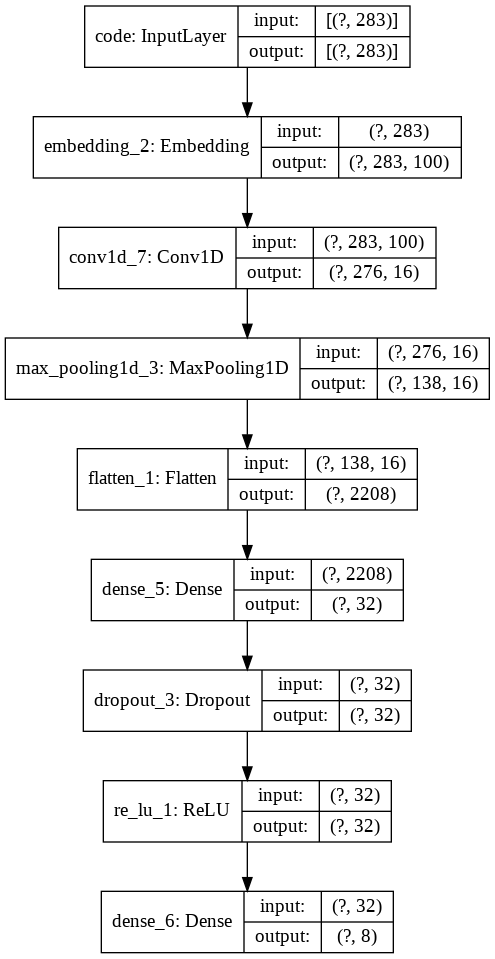

In [ ]:
keras.utils.plot_model(model2,"image_model2.png", show_shapes=True)

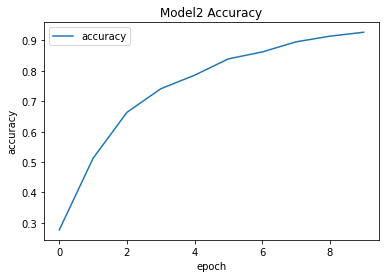

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history_model2.history['accuracy'])
plt.title('Model2 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='upper left')
plt.show()




```
# This is formatted as code
```

# CNN and OptaLingua Model Ensemble Model

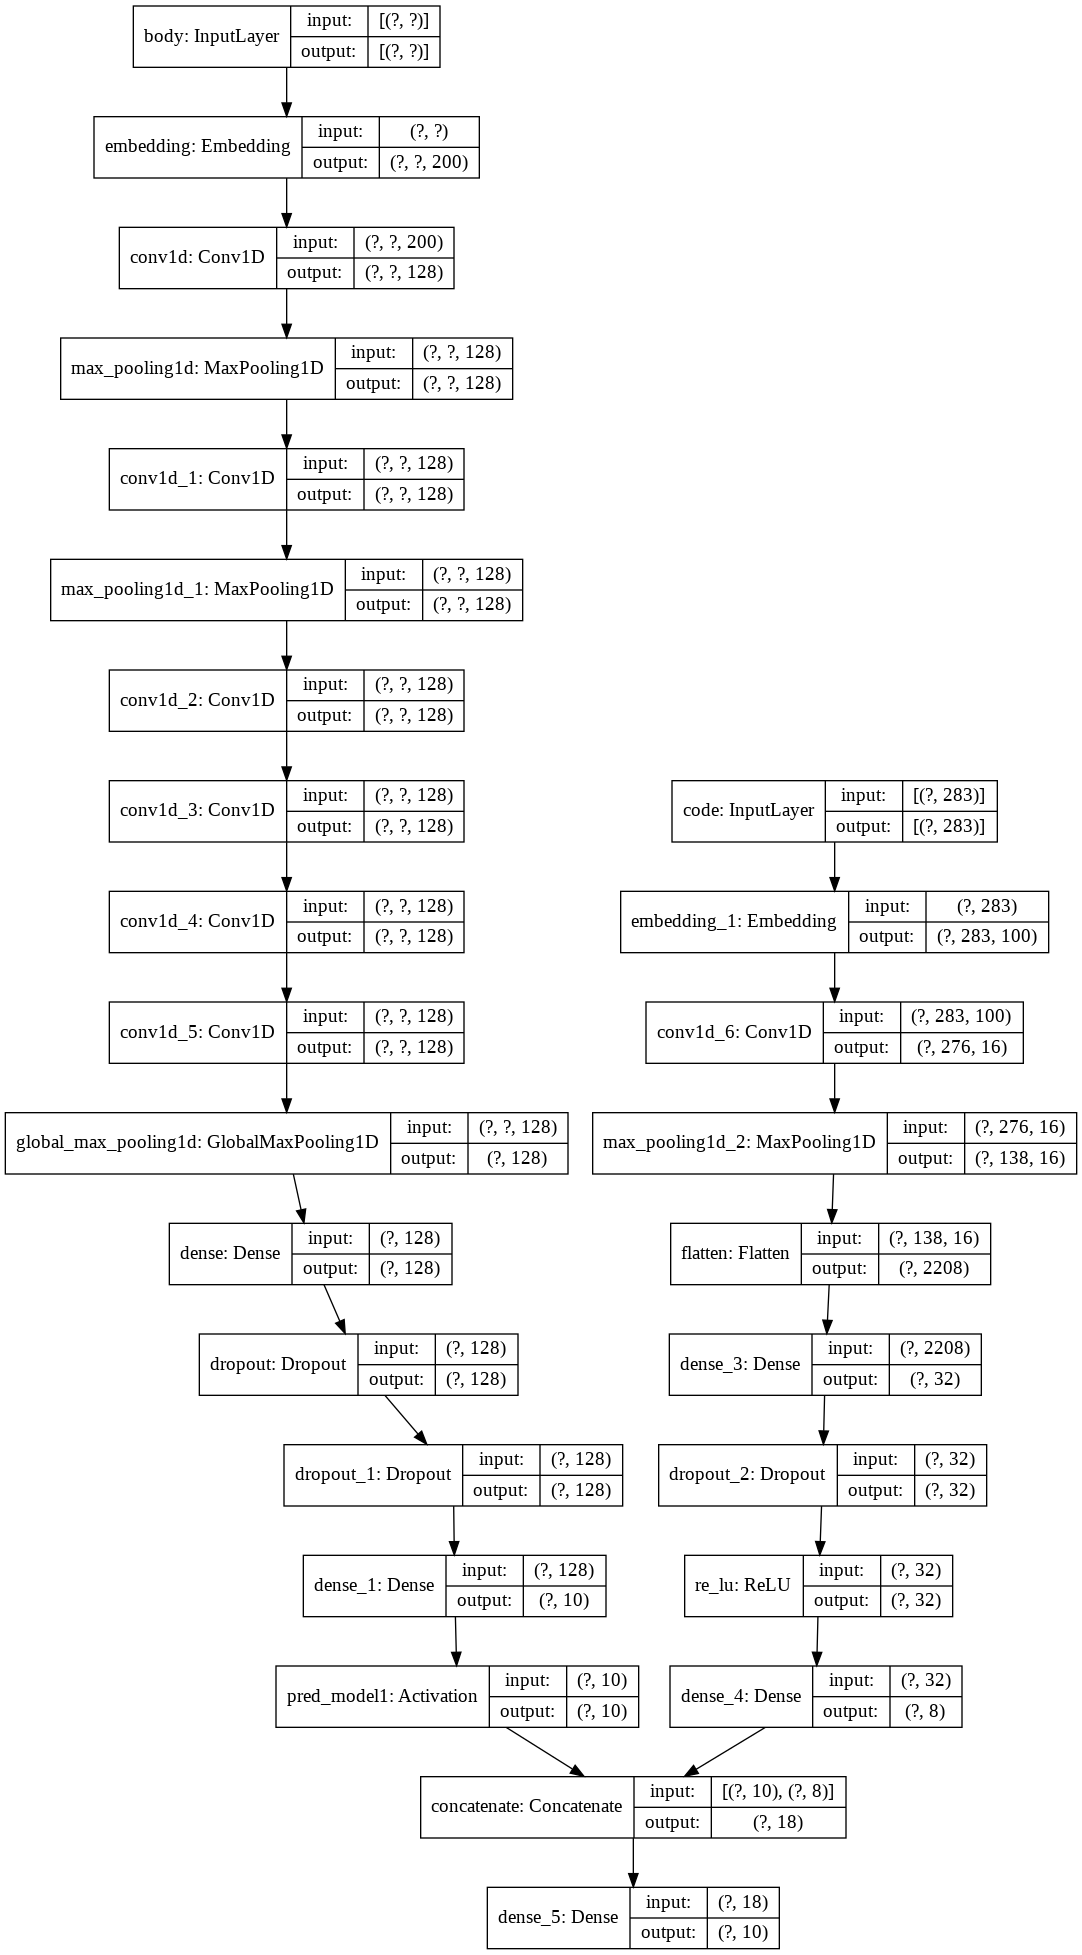

In [ ]:
#Concatenation
concat = layers.concatenate([preds_model1, prev_layer])
preds_final = layers.Dense(len(mostCommonTags))(concat)
final_model = keras.Model(inputs=[input_body, input_code], outputs=[preds_final])

keras.utils.plot_model(final_model,"image.png", show_shapes=True)

In [ ]:
# Errors out as the training distributions of the 2 models is different
from sklearn.utils import class_weight
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

final_model.compile(
              #optimizer='rmsprop',
              optimizer = keras.optimizers.Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy', precision_m, f1_m])
weights = {}

for i in range(n):
    weights[i] = (1 / tagToFrequencyList[i][1])

# history = final_model.fit(
#     {"body": train_X_body, "code": train_X_code},
#     {"pred_model1": train_y_body, "pred_model2": train_y_code},
#      batch_size=64, epochs=20, class_weight=weights)


In [ ]:
# Ensemble Method
def final_predictions(t = 0.5):
  string_input = keras.Input(shape=(1,), dtype="string")
  x = vectorizer(string_input)
  model1_preds = model1(x)
  end_to_end_model_1 = keras.Model(string_input, model1_preds)
  tags_model2 =["go",	"java",	"javascript",	"m",	"python",	"bash",	"swift",	"xml"]
  final_labels=[]
  match_count = 0
  texts = None
  for i,d in current_questions_data.iterrows():
    # Model 1
    model1_preds = end_to_end_model_1.predict([d['Body']])
    final_preds = model1_preds
    # Model 2
    if len(d['Code']) > 0:
      test_df, texts = test_on_code(d['Code'])
      model2_preds = model2.predict(test_df)
      model2_preds = np.pad(model2_preds, (0,2), 'constant')
      # go,m,bash,swift, xml as 0
      model2_preds[0][0] = 0
      model2_preds[0][3] = 0
      model2_preds[0][5] = 0
      model2_preds[0][6] = 0
      model2_preds[0][7] = 0
      # Adding weights to the 2 models - model1 and model 2 based on the threshold passed
      final_preds[0][1] = final_preds[0][1]*(1-t) + model2_preds[0][1]*t
      final_preds[0][5] = final_preds[0][5]*(1-t) + model2_preds[0][2]*t
      final_preds[0][9] = final_preds[0][9]*(1-t) + model2_preds[0][4]*t
    final_index = tagToFrequencyList[np.argmax(final_preds)][0]
    final_label = tagIndexToTag[final_index]
    if final_label == current_tag:
      match_count = match_count+1
    final_labels.append(final_label)
  return final_labels


# Testing the Ensemble Model

In [ ]:
current_questions_data = questions_data_java
current_tag = "java"

In [ ]:
def clean_code(text):
    
    doc_tokens = text.split(' ')
    doc_tokens = [w for w in doc_tokens if w in tokens]
    doc_tokens = ' '.join(doc_tokens)
    
    return doc_tokens

In [ ]:
def test_on_code(code):
    texts = []
    text = re.sub(' +',' '," ".join(re.split(r'[^\w]', re.sub(re.compile("/\*.*?\*/",re.DOTALL ) ,"" , code))))  
    text = text.lower()
    text = clean_code(text)
    texts.append(text)
        
    encoded_docs = tokenizer.texts_to_sequences(texts)
    X = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    
    return X, texts

In [ ]:
for t in np.arange(0,1,0.1):
  final_labels = final_predictions(t)

0.0 java
MISMATCH
//M=Monday,t=Tuesday,T=Thursday.... etc
$schedule["A"]["Winter"]='M';
$schedule["A"]["Spring"]='tTS';
$schedule["A"]["Summer"]='Any';
$schedule["A"]["Fall"]='tTS';
$schedule["B"]["Winter"]='t';
 $seasons["Summer"]["start"]=0501;
$seasons["Summer"]["end"]=0801;

['monday tuesday thursday etc schedule schedule tts schedule any schedule fall tts schedule start end']
5
['java', 'java', 'java', 'java', 'java']
5
0.1 java
MISMATCH
//M=Monday,t=Tuesday,T=Thursday.... etc
$schedule["A"]["Winter"]='M';
$schedule["A"]["Spring"]='tTS';
$schedule["A"]["Summer"]='Any';
$schedule["A"]["Fall"]='tTS';
$schedule["B"]["Winter"]='t';
 $seasons["Summer"]["start"]=0501;
$seasons["Summer"]["end"]=0801;

['monday tuesday thursday etc schedule schedule tts schedule any schedule fall tts schedule start end']
5
['java', 'java', 'java', 'java', 'java']
5
0.2 java
MISMATCH
//M=Monday,t=Tuesday,T=Thursday.... etc
$schedule["A"]["Winter"]='M';
$schedule["A"]["Spring"]='tTS';
$schedule["A"]["Summer

# BERT Baed Model

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers

import tensorflow as tf

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-large-uncased')

In [ ]:
def regular_encode(texts, tokenizer, maxlen = 512):
    enc_di = tokenizer.batch_encode_plus(texts, return_attention_masks = False, return_token_type_ids = False, pad_to_max_length = True, max_length = maxlen)
    return np.array(enc_di['input_ids'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(questions_data['Body'], questions_data['Top-Tags'], train_size=0.80, random_state=200)
print(len(X_train))
print(len(train_y))
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen = 128)
ytrain_encoded = tf.keras.utils.to_categorical(train_y, num_classes = 15, dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen = 128)
ytest_encoded = tf.keras.utils.to_categorical(test_y, num_classes = 15, dtype = 'int32')
print(len(Xtrain_encoded))
print(len(ytrain_encoded))
print(len(train_y))

In [ ]:
from sklearn.utils import class_weight
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

weights = {}
for i in range(n):
    weights[i] = (1 / tagToFrequencyList[i][1])
vals = [val for val in weights.values()]

def build_model(transformer, loss = 'binary_crossentropy', max_len = 512):
    input_word_ids = tf.keras.layers.Input(shape = (max_len,), dtype = tf.int32, name = "input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]

    #adding dropout layer
    x = tf.keras.layers.Dropout(0.40)(cls_token)

    out = tf.keras.layers.Dense(len(mostCommonTags))(x)
    out = tf.keras.layers.Activation(activation="sigmoid")(out)

    model = tf.keras.Model(inputs = input_word_ids, outputs = out)
    model.compile(tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=2), precision_m, f1_m, tf.keras.metrics.AUC(curve="PR", multi_label=True, label_weights=vals)])
    return model

In [ ]:
transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
model = build_model(transformer_layer, max_len = 128)
model.summary()

In [ ]:
BATCH_SIZE = 4
AUTO = tf.data.experimental.AUTOTUNE 
print(len(Xtrain_encoded))
print(len(ytrain_encoded))
train_dataset = (tf.data.Dataset.from_tensor_slices((Xtrain_encoded, train_y)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))
test_dataset = (tf.data.Dataset.from_tensor_slices(Xtest_encoded).batch(BATCH_SIZE))

In [ ]:
n_steps = Xtrain_encoded.shape[0] 
train_history = model.fit(train_dataset, steps_per_epoch = n_steps, epochs = 20)